# Brain Tumor Classification (MRI)

In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

## Importing Data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [5]:
train_data = train_df('D:\Mahir\Datasets\Merged Dataset 2\Training')

In [6]:
train_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
1,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
2,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
3,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
4,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
...,...,...
16983,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16984,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16985,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16986,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary


In [7]:
test_data = test_df('D:\Mahir\Datasets\Merged Dataset 2\Testing')

In [8]:
test_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
1,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
2,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
3,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
4,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
...,...,...
4322,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4323,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4324,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4325,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary


## Data Visualization

In [10]:
train_path = 'D:\Mahir\Datasets\Merged Dataset 2\Training'
test_path = 'D:\Mahir\Datasets\Merged Dataset 2\Testing'

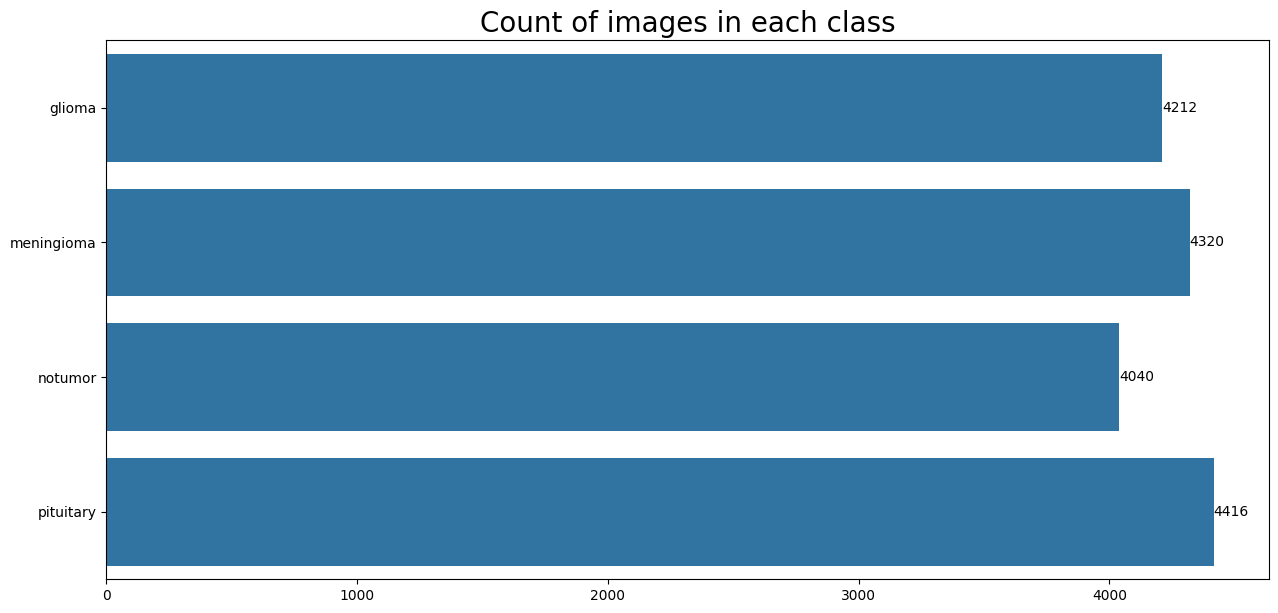

In [11]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_data , y=train_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

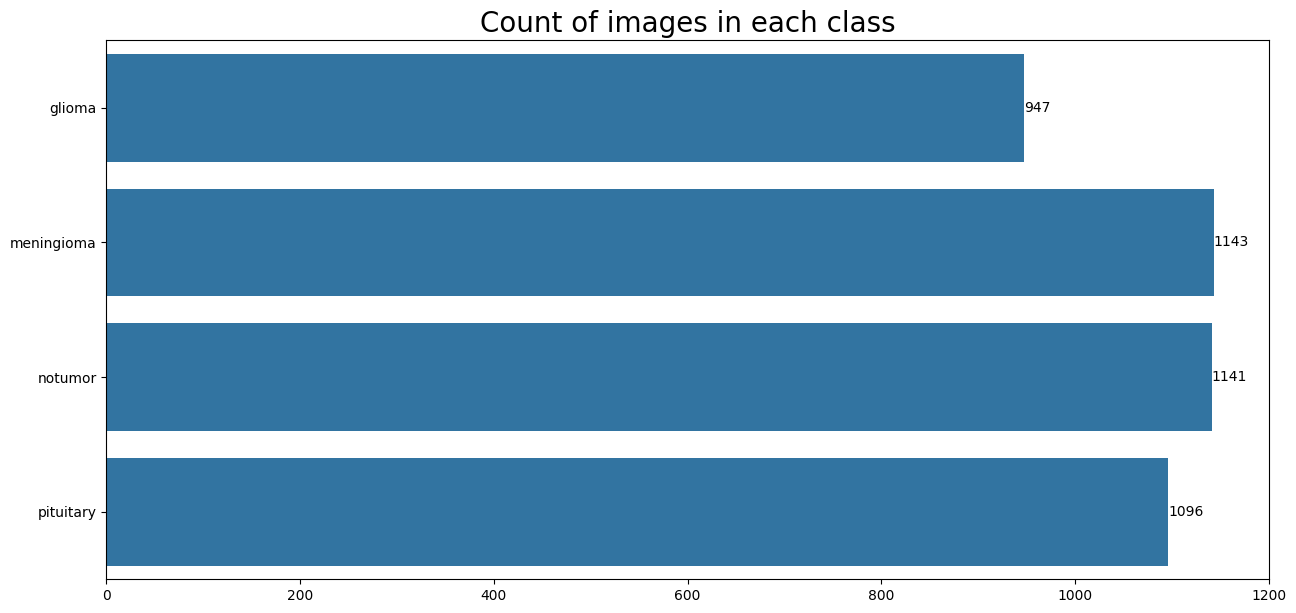

In [12]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_data , y=test_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

## Data Preprocessing

In [13]:
# Image size
image_size = (160, 160)

# Training batch size
batch_size = 32

In [14]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(test_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                seed=0)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 16988 images belonging to 4 classes.
Found 2162 images belonging to 4 classes.
Found 4327 images belonging to 4 classes.


In [15]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

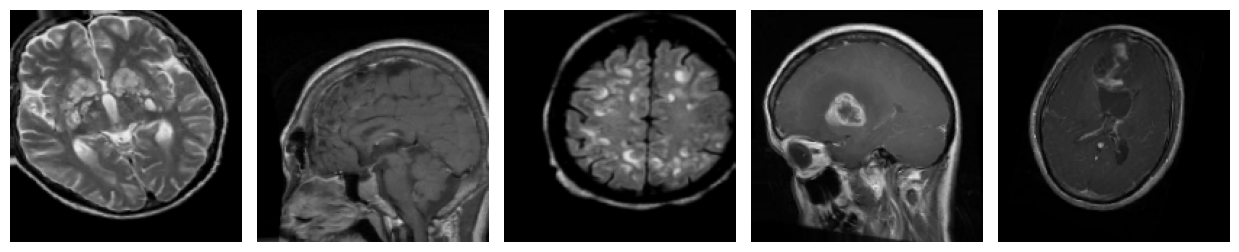

In [16]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

### Training Setup

In [17]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (160, 160, 3)
Batch size: 32
Number of Train batches: 531
Number of Validation batches: 68
Number of Testing batches: 136


In [18]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [19]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

## VGG16 Model

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_epochs = 50

early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint_path = r'D:\Mahir\Brain\Brain-Tumor-Classification-Research\Build Model\Vgg16\Vgg16_Aug_D2.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

vgg_history = model_vgg.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[early_stopper, model_checkpoint]
)

model_vgg.load_weights(checkpoint_path)

model_vgg.summary()


Epoch 1/50
531/531 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8521
Epoch 1: val_loss improved from inf to 0.21019, saving model to D:\Mahir\Brain\Brain-Tumor-Classification-Research\Build Model\Vgg16\Vgg16_Aug_D2.keras
531/531 [==============================] - 204s 366ms/step - loss: 0.3914 - accuracy: 0.8521 - val_loss: 0.2102 - val_accuracy: 0.9311
Epoch 2/50
531/531 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9593
Epoch 2: val_loss did not improve from 0.21019
531/531 [==============================] - 117s 220ms/step - loss: 0.1254 - accuracy: 0.9593 - val_loss: 0.2422 - val_accuracy: 0.9315
Epoch 3/50
531/531 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9740
Epoch 3: val_loss improved from 0.21019 to 0.12881, saving model to D:\Mahir\Brain\Brain-Tumor-Classification-Research\Build Model\Vgg16\Vgg16_Aug_D2.keras
531/531 [==============================] - 118s 223ms/step - loss: 0.0814 - accuracy: 0

### VGG16 Model Evaluation

In [25]:
model_vgg.save('Vgg16_Aug_D2.h5')

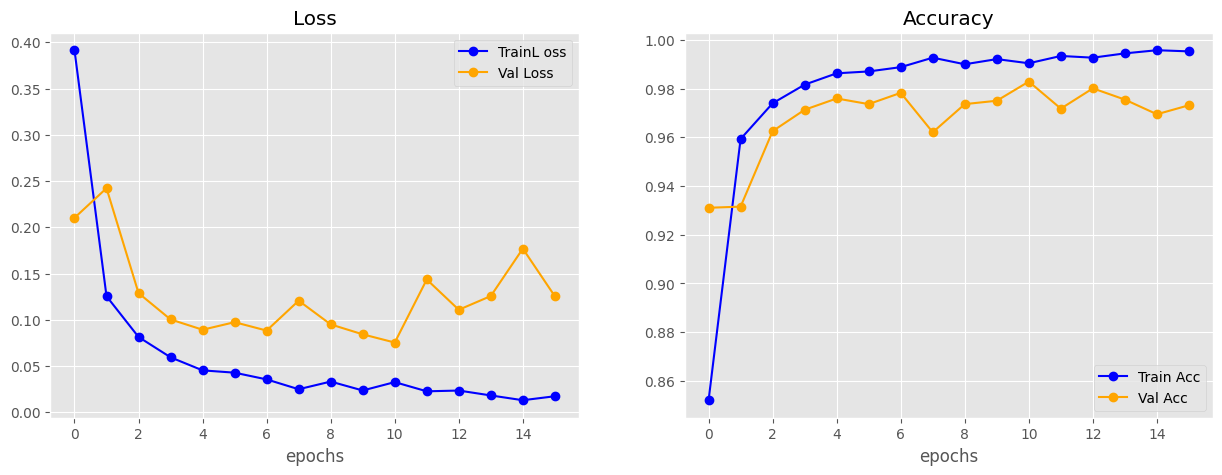

In [26]:
plot_curves(vgg_history)

In [30]:
train_score = model_vgg.evaluate(train_generator, verbose=1)
valid_score = model_vgg.evaluate(val_generator, verbose=1)
test_score = model_vgg.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


136/136 [==============================] - 17s 126ms/step - loss: 0.1209 - accuracy: 0.9806
Train Loss: 0.0078
Train Accuracy: 99.76%
--------------------
Validation Loss: 0.0754
Validation Accuracy: 98.29%
--------------------
Test Loss: 0.1209
Test Accuracy: 98.06%


136/136 [==============================] - 8s 61ms/step


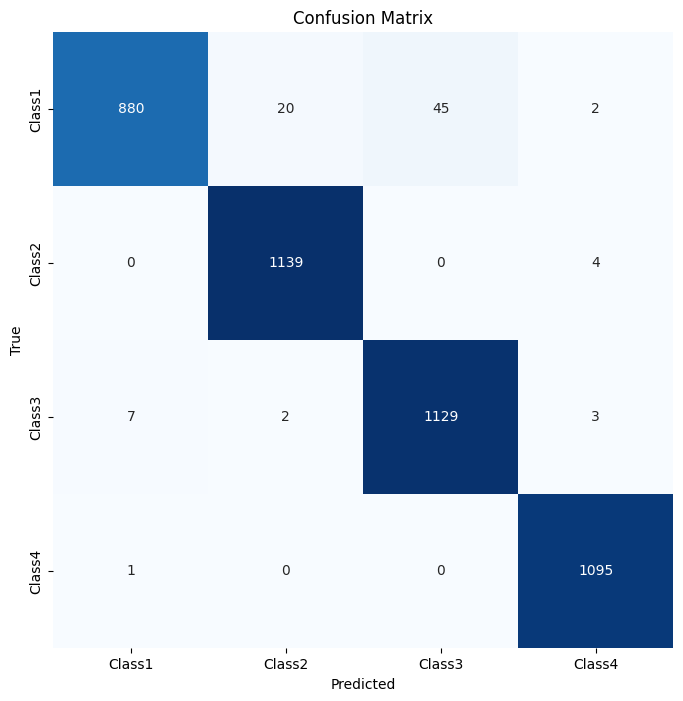

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as CM

# Define your classes (replace with your actual class names)
classes = ["Class1", "Class2", "Class3", "Class4"]  # Example class names

# Generate predictions
y_true = test_generator.classes
y_pred = np.argmax(model_vgg.predict(test_generator), axis=-1)

# Compute confusion matrix
conf_matrix = CM(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], va='center')
plt.show()
